## Map seasonality of plankton biomass and NO$_3$ concentrations

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from numpy import arange,array,ones
from scipy import stats
import re 
import os

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [4]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

# Stack all of the plankton in one single array 

In [5]:
%%time
planktonC = np.stack([ds.ppC, ds.mp1C, 
                      ds.diat1C, ds.mp2C, ds.diat2C, 
                      ds.mp3C, ds.diat3C, ds.mp4C,
                      ds.zoo1C, ds.zoo2C, ds.zoo3C, 
                      ds.zoo4C, ds.zoo5C, ds.zoo6C])

CPU times: user 1.48 s, sys: 14.1 s, total: 15.5 s
Wall time: 38.3 s


In [6]:
import cartopy.crs as ccrs
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

In [7]:
# phytoplankton
phytoC_bm = np.nansum(planktonC[0:8,:,:,:,:],axis=(0,2)) #mmol m^-3

#zooplankton
zooC_bm = np.nansum(planktonC[8::,:,:,:,:],axis=(0,2)) #mmol m^-3

In [9]:
ds.NO3

<xarray.DataArray 'NO3' (time: 12, z_t: 60, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(12, 60, 384, 320), dtype=float32, chunksize=(1, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Dissolved Inorganic Nitrate
    units:         mmol/m^3
    grid_loc:      3111
    cell_methods:  time: mean

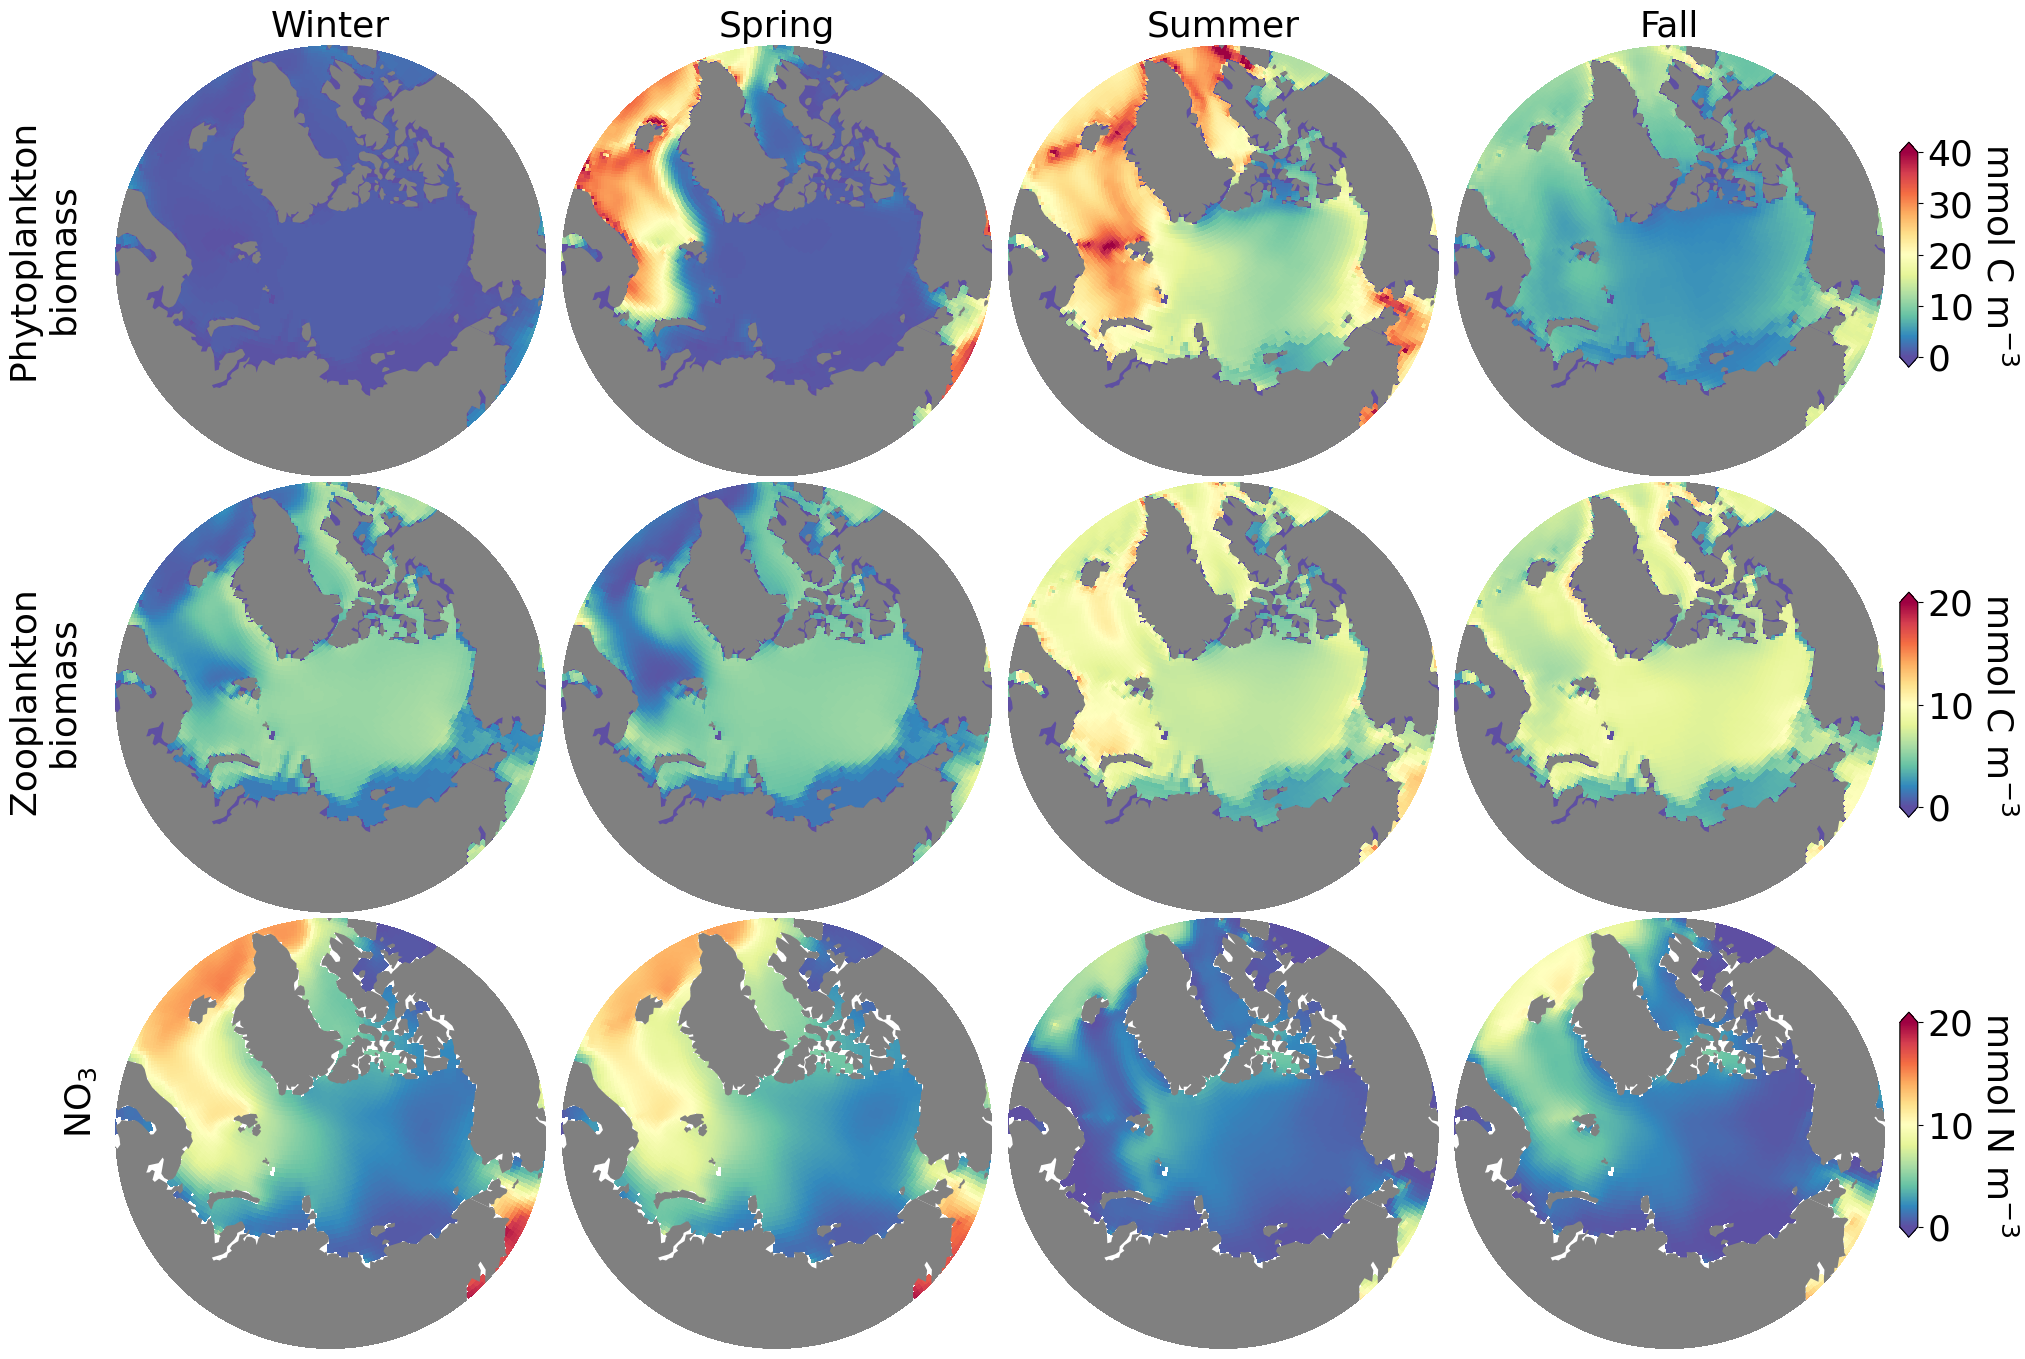

In [10]:
import matplotlib.ticker as ticker
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${}'.format(a, b)

#---------------------------------------------------------------------
fig = plt.figure(figsize=(18, 15))
#---------------------------------------------------------------------
x_lon = ds.TLONG
y_lat= ds.TLAT
vminn=0
vmaxx=40
font=26

#-------------------- Cartopy Settings -------------------------------
r_limit = 3214068.5
r_extent = r_limit*1.0001
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=180+(-100+-30)/2, central_latitude=90)
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,circle_path.codes.copy())

# -------------  Historical  ---------------------------------------
ax = fig.add_subplot(3, 4, 1,projection=my_projn)
x, y, hist_w = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_bm[list(range(2)) + [-1],:,:],axis=0))
cf = ax.pcolormesh(x, y, hist_w, cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Winter', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 2,projection=my_projn)
x, y, hist_sp = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_bm[2:5,:,:],axis=0))
ax.set_title('Spring', fontsize =font)
cf = ax.pcolormesh(x, y, hist_sp, cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 3,projection=my_projn)
x, y, hist_su = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_bm[5:8,:,:],axis=0))
ax.set_title('Summer', fontsize =font)
cf = ax.pcolormesh(x, y, hist_su, cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 4,projection=my_projn)
x, y, hist_f = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_bm[8:11,:,:],axis=0))
ax.set_title('Fall', fontsize =font)
cf = ax.pcolormesh(x, y, hist_f, cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

cbar_ax = fig.add_axes([0.9999, 0.72, 0.01, 0.15])
ticks = np.linspace(0, vmaxx, 5, endpoint=True)
cb = fig.colorbar(cf, ticks=ticks,shrink=1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('mmol C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)

#-------------------------------------------------------------------------
#           Zooplankton Biomass  
#-------------------------------------------------------------------------
vminn=0
vmaxx=20
ax = fig.add_subplot(3, 4, 5,projection=my_projn)
x, y, ssp1_w = adjust_pop_grid(x_lon, y_lat, np.nanmean(zooC_bm[list(range(2)) + [-1],:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp1_w, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 6,projection=my_projn)
x, y, ssp1_sp = adjust_pop_grid(x_lon, y_lat, np.nanmean(zooC_bm[2:5,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp1_sp, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 7,projection=my_projn)
x, y, ssp1_su = adjust_pop_grid(x_lon, y_lat, np.nanmean(zooC_bm[5:8,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp1_su, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 8,projection=my_projn)
x, y, ssp1_f = adjust_pop_grid(x_lon, y_lat, np.nanmean(zooC_bm[8:11,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp1_f, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame
cbar_ax = fig.add_axes([0.9999, 0.42, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('mmol C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)
#-------------------------------------------------------------------------
#           NO3  
#-------------------------------------------------------------------------
vminn=0
vmaxx=20
ax = fig.add_subplot(3, 4, 9,projection=my_projn)
x, y, ssp2_w = adjust_pop_grid(x_lon, y_lat, np.nanmean(ds.NO3[list(range(2)) + [-1],0,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp2_w, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 10,projection=my_projn)
x, y, ssp2_sp = adjust_pop_grid(x_lon, y_lat, np.nanmean(ds.NO3[2:5,0,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp2_sp, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 11,projection=my_projn)
x, y, ssp2_su = adjust_pop_grid(x_lon, y_lat, np.nanmean(ds.NO3[5:8,0,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp2_su, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(3, 4, 12,projection=my_projn)
x, y, ssp2_f = adjust_pop_grid(x_lon, y_lat, np.nanmean(ds.NO3[8:11,0,:,:],axis=0))
cf =  ax.pcolormesh(x, y, ssp2_f, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0001,
    hspace=-0.4)

cbar_ax = fig.add_axes([0.9999, 0.14, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1,extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('mmol N m$^{-3}$', fontsize =font,rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)
fig.text(-0.05, 0.8, 'Phytoplankton \n    biomass', va='center', rotation='vertical',fontsize=font)
fig.text(-0.05, 0.5, 'Zooplankton \n    biomass', va='center', rotation='vertical',fontsize=font)
fig.text(-0.02, 0.23, 'NO$_3$', va='center', rotation='vertical',fontsize=font)
fig.tight_layout()
#-------------------------------------------------------------------------
#                             SAVE FIGURE 
#-------------------------------------------------------------------------

figures_file = '/glade/u/home/gabyn/work/case_notes/analysis_figures'
fig.savefig(''+figures_file+'/seasonal_biomass_&_NO3_GNG595_20yrclim.png', bbox_inches="tight", dpi=600)

## Incorporate Flux bottom depth - 20 year average 

flux_bottom = np.load("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/flux_bottom_62yr.npy")

In [14]:
# Flux = ds.POC_FLUX_IN[:,:,:,:].mean(dim='time') * (60*60*24*365)/100 * 12.011 / 1e3 # mmol/m^3 cm/s --> mmol/m^2/y ----> g/m^2/y

kmt_bottom = np.nanmean(ds.KMT,axis=0)
flux_bottom = np.empty([12,384,320]) # Size of the array that I need
flux_bottom[:] = np.nan # make everything a nan inside of it
for i in range(384): # loop through the latitude 
    for j in range(320): # loop through the longitude 
        # For each lat and lon, find the bottom depth, and select that flux as the bottom flux of each grid cell. 
        # I averaged the bottom depth annually before becuase I do not expect the bottom depth to change seasonally right?
        if kmt_bottom[i,j] == 0: 
            flux_bottom[:,i,j] =  ds.POC_FLUX_IN[:,0,i,j]# mmol/m^3 cm/s
        else:
            flux_bottom[:,i,j] =  ds.POC_FLUX_IN[:,int(kmt_bottom[i,j])-1,i,j]# mmol/m^3 cm/s
            
            
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/flux_bottom_20yrclim.npy",flux_bottom)

In [11]:
flux_bottom = np.load("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/flux_bottom_20yrclim.npy")

In [12]:
flux_bottom_depth = np.nanmean(flux_bottom,axis=0) * (60*60*24*365)/100 * 12.011 / 1e3 #g/m^2/y

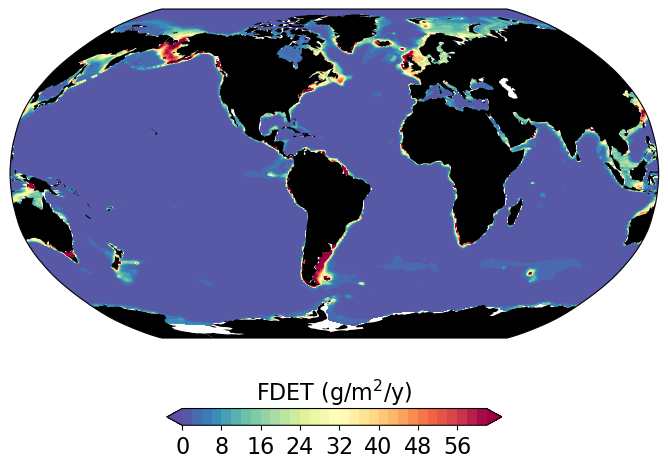

In [13]:
fig = plt.figure(figsize=(7, 5))
lev = np.arange(0, 64, 2)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=32)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, flux_bottom_depth)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('FDET (g/m$^2$/y)', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

In [14]:
flux_bottom_depth = flux_bottom * (60*60*24)/100 * 12.011 / 1e3 #g/m^2/d

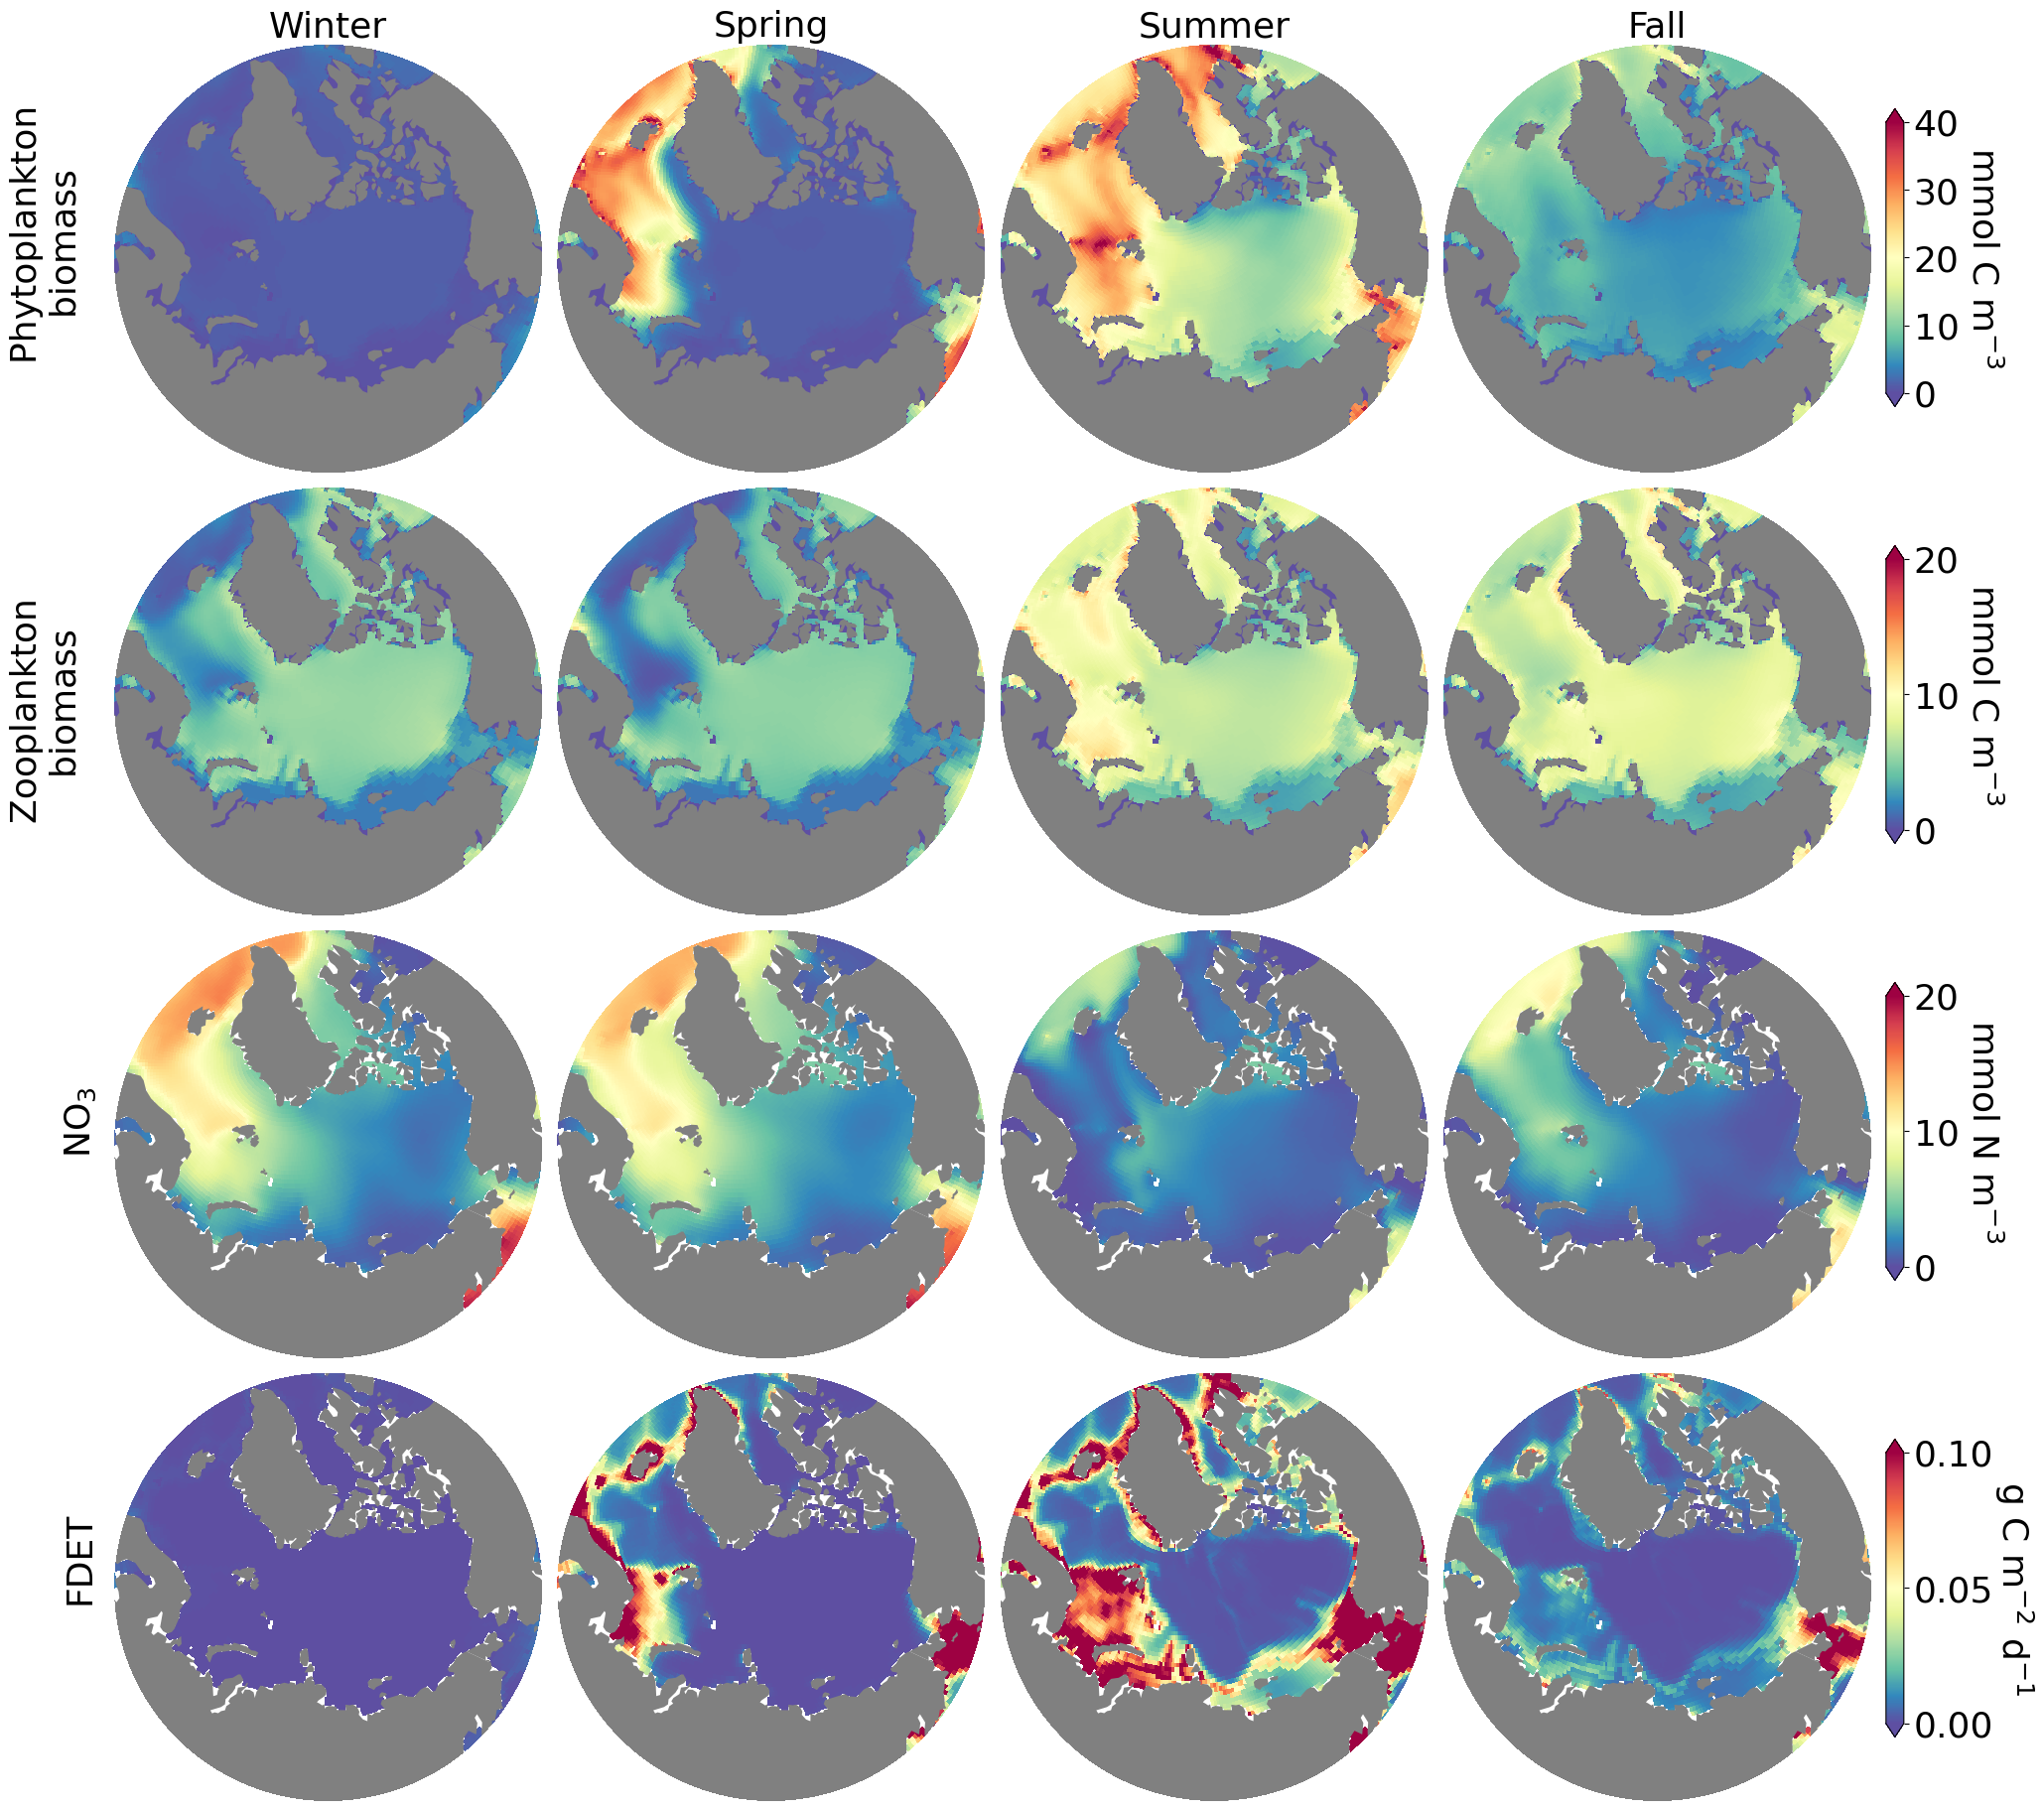

In [15]:
import matplotlib.ticker as ticker
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${}'.format(a, b)

#---------------------------------------------------------------------
fig = plt.figure(figsize=(18, 20))
#---------------------------------------------------------------------
x_lon = ds.TLONG
y_lat= ds.TLAT
vminn=0
vmaxx=40
font=26

#-------------------- Cartopy Settings -------------------------------
r_limit = 3214068.5
r_extent = r_limit*1.0001
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=180+(-100+-30)/2, central_latitude=90)
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,circle_path.codes.copy())

# -------------  Historical  ---------------------------------------
ax = fig.add_subplot(4, 4, 1,projection=my_projn)
x, y, hist_w = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_bm[list(range(2)) + [-1],:,:],axis=0))
cf = ax.pcolormesh(x, y, hist_w, cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.set_title('Winter', fontsize =font)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 2,projection=my_projn)
x, y, hist_sp = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_bm[2:5,:,:],axis=0))
ax.set_title('Spring', fontsize =font)
cf = ax.pcolormesh(x, y, hist_sp, cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 3,projection=my_projn)
x, y, hist_su = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_bm[5:8,:,:],axis=0))
ax.set_title('Summer', fontsize =font)
cf = ax.pcolormesh(x, y, hist_su, cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 4,projection=my_projn)
x, y, hist_f = adjust_pop_grid(x_lon, y_lat, np.nanmean(phytoC_bm[8:11,:,:],axis=0))
ax.set_title('Fall', fontsize =font)
cf = ax.pcolormesh(x, y, hist_f, cmap='Spectral_r', vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

cbar_ax = fig.add_axes([0.9999, 0.76, 0.01, 0.15])
ticks = np.linspace(0, vmaxx, 5, endpoint=True)
cb = fig.colorbar(cf, ticks=ticks,shrink=1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('mmol C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)

#-------------------------------------------------------------------------
#           Zooplankton Biomass  
#-------------------------------------------------------------------------
vminn=0
vmaxx=20
ax = fig.add_subplot(4, 4, 5,projection=my_projn)
x, y, ssp1_w = adjust_pop_grid(x_lon, y_lat, np.nanmean(zooC_bm[list(range(2)) + [-1],:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp1_w, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 6,projection=my_projn)
x, y, ssp1_sp = adjust_pop_grid(x_lon, y_lat, np.nanmean(zooC_bm[2:5,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp1_sp, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 7,projection=my_projn)
x, y, ssp1_su = adjust_pop_grid(x_lon, y_lat, np.nanmean(zooC_bm[5:8,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp1_su, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 8,projection=my_projn)
x, y, ssp1_f = adjust_pop_grid(x_lon, y_lat, np.nanmean(zooC_bm[8:11,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp1_f, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame
cbar_ax = fig.add_axes([0.9999, 0.54, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('mmol C m$^{-3}$', fontsize =font, rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)
#-------------------------------------------------------------------------
#           NO3  
#-------------------------------------------------------------------------
vminn=0
vmaxx=20
ax = fig.add_subplot(4, 4, 9,projection=my_projn)
x, y, ssp2_w = adjust_pop_grid(x_lon, y_lat, np.nanmean(ds.NO3[list(range(2)) + [-1],0,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp2_w, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 10,projection=my_projn)
x, y, ssp2_sp = adjust_pop_grid(x_lon, y_lat, np.nanmean(ds.NO3[2:5,0,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp2_sp, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 11,projection=my_projn)
x, y, ssp2_su = adjust_pop_grid(x_lon, y_lat, np.nanmean(ds.NO3[5:8,0,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp2_su, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 12,projection=my_projn)
x, y, ssp2_f = adjust_pop_grid(x_lon, y_lat, np.nanmean(ds.NO3[8:11,0,:,:],axis=0))
cf =  ax.pcolormesh(x, y, ssp2_f, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame
cbar_ax = fig.add_axes([0.9999, 0.32, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1,extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('mmol N m$^{-3}$', fontsize =font,rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)

#-------------------------------------------------------------------------
#           FDET   (#g/m^2/d)
#-------------------------------------------------------------------------
vminn=0
vmaxx=0.1
ax = fig.add_subplot(4, 4, 13,projection=my_projn)
x, y, ssp2_w = adjust_pop_grid(x_lon, y_lat, np.nanmean(flux_bottom_depth[list(range(2)) + [-1],:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp2_w, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 14,projection=my_projn)
x, y, ssp2_sp = adjust_pop_grid(x_lon, y_lat, np.nanmean(flux_bottom_depth[2:5,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp2_sp, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 15,projection=my_projn)
x, y, ssp2_su = adjust_pop_grid(x_lon, y_lat, np.nanmean(flux_bottom_depth[5:8,:,:],axis=0))
cf = ax.pcolormesh(x, y, ssp2_su, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

ax = fig.add_subplot(4, 4, 16,projection=my_projn)
x, y, ssp2_f = adjust_pop_grid(x_lon, y_lat, np.nanmean(flux_bottom_depth[8:11,:,:],axis=0))
cf =  ax.pcolormesh(x, y, ssp2_f, cmap='Spectral_r',vmin=vminn, vmax=vmaxx,transform=lonlatproj);
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
ax.set_xlim(-r_extent, r_extent); ax.set_ylim(-r_extent, r_extent)
ax.set_boundary(circle_path); ax.set_frame_on(False)  #hide the rectangle frame

plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0001,
    hspace=-0.4)

cbar_ax = fig.add_axes([0.9999, 0.09, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1,extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_label('g C m$^{-2}$ d$^{-1}$', fontsize =font,rotation=-90, labelpad=30)
cb.ax.tick_params(labelsize=font)
fig.text(-0.05, 0.85, 'Phytoplankton \n    biomass', va='center', rotation='vertical',fontsize=font)
fig.text(-0.05, 0.61, 'Zooplankton \n    biomass', va='center', rotation='vertical',fontsize=font)
fig.text(-0.02, 0.4, 'NO$_3$', va='center', rotation='vertical',fontsize=font)
fig.text(-0.02, 0.18, 'FDET', va='center', rotation='vertical',fontsize=font)
fig.tight_layout()
#-------------------------------------------------------------------------
#                             SAVE FIGURE 
#-------------------------------------------------------------------------

figures_file = '/glade/u/home/gabyn/work/case_notes/analysis_figures'
fig.savefig(''+figures_file+'/seasonal_biomass_NO3_&_FDET_GNG595_20yrclim.png', bbox_inches="tight", dpi=600)